### Installing Depencencies

In [ ]:
library(data.table)
library(MOFA2)
library(R.utils)

# Loading data 
### *Possible formats of data:*
* List of matrices = each enty corresponds to one view
* Long `data.frame` = with cols: `sample`, `feature`, `view`, `value`
* MultiAssayExperiment: to connect with Bioconductor objects
* Seurat: only for single-cell genomics users

## List of Matrices

In [3]:
# List of Matrices, simulated data

data <- make_example_data(
  n_views = 2, 
  n_samples = 200, 
  n_features = 1000, 
  n_factors = 10
)[[1]]

lapply(data,dim)

$view_1
[1] 1000  200

$view_2
[1] 1000  200

In [4]:
MOFAobject <- create_mofa(data)

Creating MOFA object from a list of matrices (features as rows, sample as columns)...




In [5]:
# Using groups
N = ncol(data[[1]])
groups = c(rep("A",N/2), rep("B",N/2))

MOFAobject <- create_mofa(data, groups=groups)

Creating MOFA object from a list of matrices (features as rows, sample as columns)...




## Long `data.frame`

In [9]:
dt = fread("ftp://ftp.ebi.ac.uk/pub/databases/mofa/getting_started/data.txt.gz")
head(dt)

sample,group,feature,view,value
<chr>,<chr>,<chr>,<chr>,<dbl>
sample_0_group_0,group_0,feature_0_view_0,view_0,-2.05
sample_1_group_0,group_0,feature_0_view_0,view_0,0.10
sample_2_group_0,group_0,feature_0_view_0,view_0,1.44
sample_3_group_0,group_0,feature_0_view_0,view_0,-0.28
sample_4_group_0,group_0,feature_0_view_0,view_0,-0.88
sample_5_group_0,group_0,feature_0_view_0,view_0,-1.18


In [10]:
# Ignore the grouping information
dt[,group:=NULL]

In [11]:
MOFAobject <- create_mofa(dt)

Creating MOFA object from a data.frame...



In [12]:
print(MOFAobject)

Untrained MOFA model with the following characteristics: 
 Number of views: 2 
 Views names: view_0 view_1 
 Number of features (per view): 1000 1000 
 Number of groups: 1 
 Groups names: single_group 
 Number of samples (per group): 200 
 


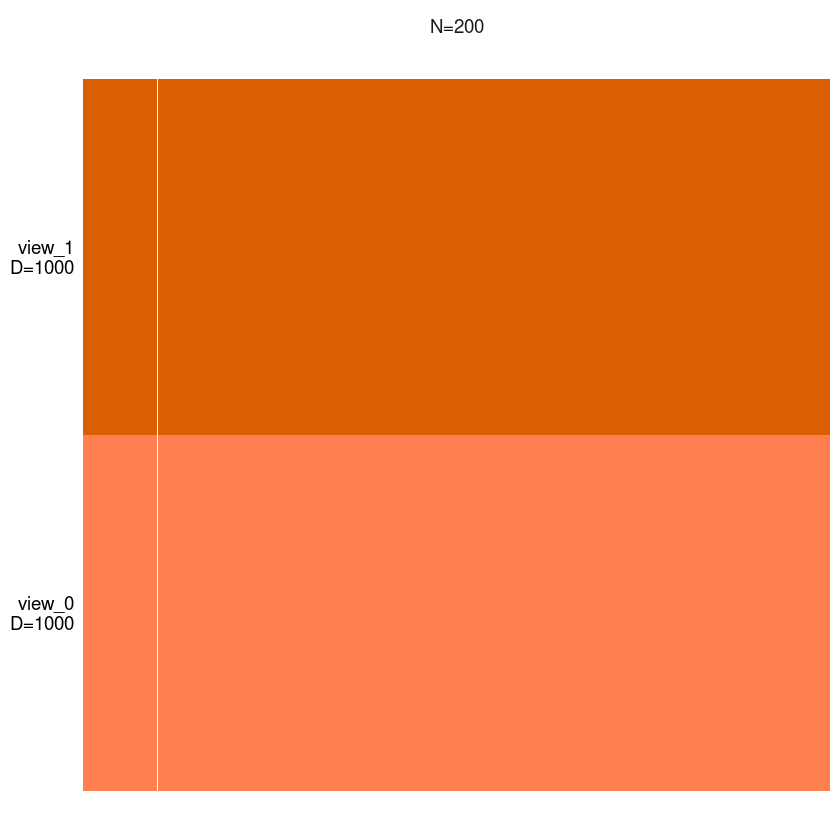

In [13]:
plot_data_overview(MOFAobject)

## Define Options

In [14]:
# Data Options
data_opts <- get_default_data_options(MOFAobject)
head(data_opts)

$scale_views
[1] FALSE

$scale_groups
[1] FALSE

$center_groups
[1] TRUE

$use_float32
[1] FALSE

$views
[1] "view_0" "view_1"

$groups
[1] "single_group"

In [15]:
# Model Options
model_opts <- get_default_model_options(MOFAobject)
head(model_opts)

$likelihoods
    view_0     view_1 
"gaussian" "gaussian" 

$num_factors
[1] 15

$spikeslab_factors
[1] FALSE

$spikeslab_weights
[1] TRUE

$ard_factors
[1] FALSE

$ard_weights
[1] TRUE

In [16]:
# Train Options
train_opts <- get_default_training_options(MOFAobject)
head(train_opts)

$maxiter
[1] 1000

$convergence_mode
[1] "fast"

$drop_factor_threshold
[1] -1

$verbose
[1] FALSE

$startELBO
[1] 1

$freqELBO
[1] 5

# Build and Train MOFA obj.

In [17]:
# Prepare MOFA obj
MOFAobject <- prepare_mofa(
  object = MOFAobject,
  data_options = data_opts,
  model_options = model_opts,
  training_options = train_opts
)

# Train
outfile = file.path(getwd(),"model.hdf5")
MOFAobject.trained <- run_mofa(MOFAobject, outfile)

Checking data options...

Checking training options...

Checking model options...

Connecting to the mofapy2 python package using reticulate (use_basilisk = FALSE)... 
    Please make sure to manually specify the right python binary when loading R with reticulate::use_python(..., force=TRUE) or the right conda environment with reticulate::use_condaenv(..., force=TRUE)
    If you prefer to let us automatically install a conda environment with 'mofapy2' installed using the 'basilisk' package, please use the argument 'use_basilisk = TRUE'


Warning message in run_mofa(MOFAobject, outfile):
“mofapy2_0.6.4 is not detected in the specified python binary, see reticulate::py_config(). Setting use_basilisk = TRUE...”
Connecting to the mofapy2 package using basilisk. 
    Set 'use_basilisk' to FALSE if you prefer to manually set the python binary using 'reticulate'.

1 factors were found to explain no variance and they were removed for downstream analysis. You can disable this option by setting 

# Downstream Analysis

In [ ]:
library(ggplot2)
library(MOFA2)

In [19]:
# load the model
filepath <- system.file("extdata", "model.hdf5", package = "MOFA2")
print(filepath)
model <- load_model(filepath)

[1] "/home/ivana/R/x86_64-pc-linux-gnu-library/4.1/MOFA2/extdata/model.hdf5"


In [21]:
# Add artificial metadata
Nsamples = sum(model@dimensions$N)

sample_metadata <- data.frame(
  sample = samples_names(model)[[1]],
  condition = sample(c("A","B"), size = Nsamples, replace = T),
  age = sample(1:100, size = Nsamples, replace = T)
)

samples_metadata(model) <- sample_metadata
head(model@samples_metadata, n=3)

,sample,condition,age,group
,<chr>,<chr>,<int>,<chr>
1,sample_0_group_1,B,30,single_group
2,sample_1_group_1,B,2,single_group
3,sample_2_group_1,B,98,single_group


# Variance Decomposition 
* quantify the amount of variance explained (R2) by each factor in each data modality, load by `model@cache[["variance_explained"]]`
* plot variance explained `plot_variance_explained(model, faxtors, x, y, split_by, plot_total)`
* visualization of a single factor `plot_factor` scatterplot/ violin plt
* visualization of a combination of factors `plot_factors`
* visualization of a feature weight `plot_weights` & `plot_top_weights` (feature with no association == 0; negative association/possittive association)

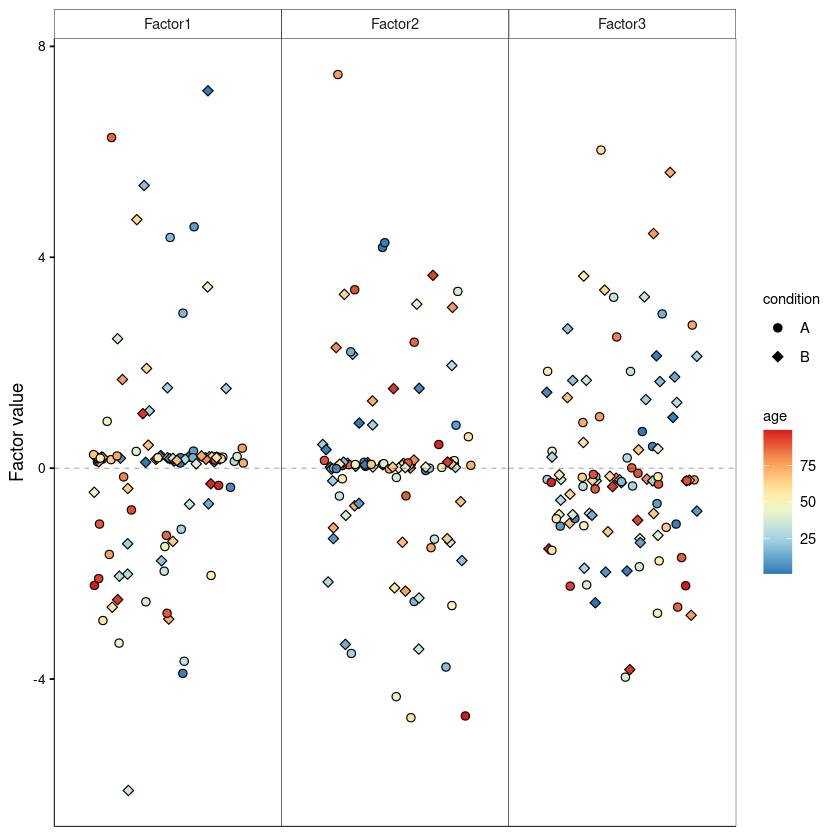

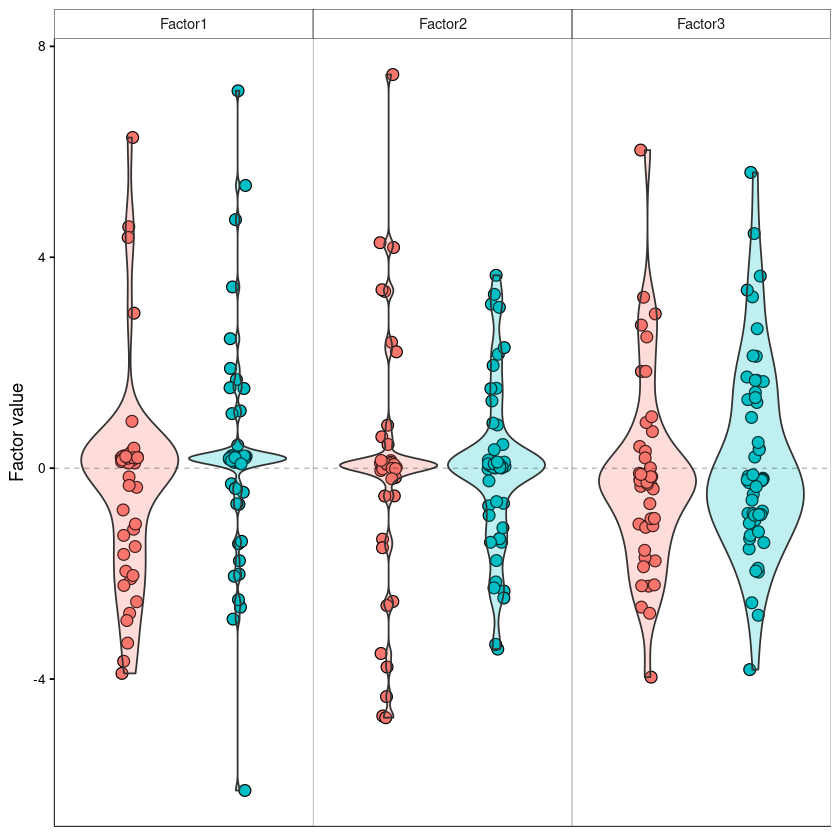

In [23]:
# Scatter
plot_factor(model, 
  factor = 1:3,
  color_by = "age",
  shape_by = "condition"
)

# Violin
p <- plot_factor(model, 
  factors = c(1,2,3),
  color_by = "condition",
  dot_size = 3,        # change dot size
  dodge = T,           # dodge points with different colors
  legend = F,          # remove legend
  add_violin = T,      # add violin plots,
  violin_alpha = 0.25  # transparency of violin plots
)


print(p)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



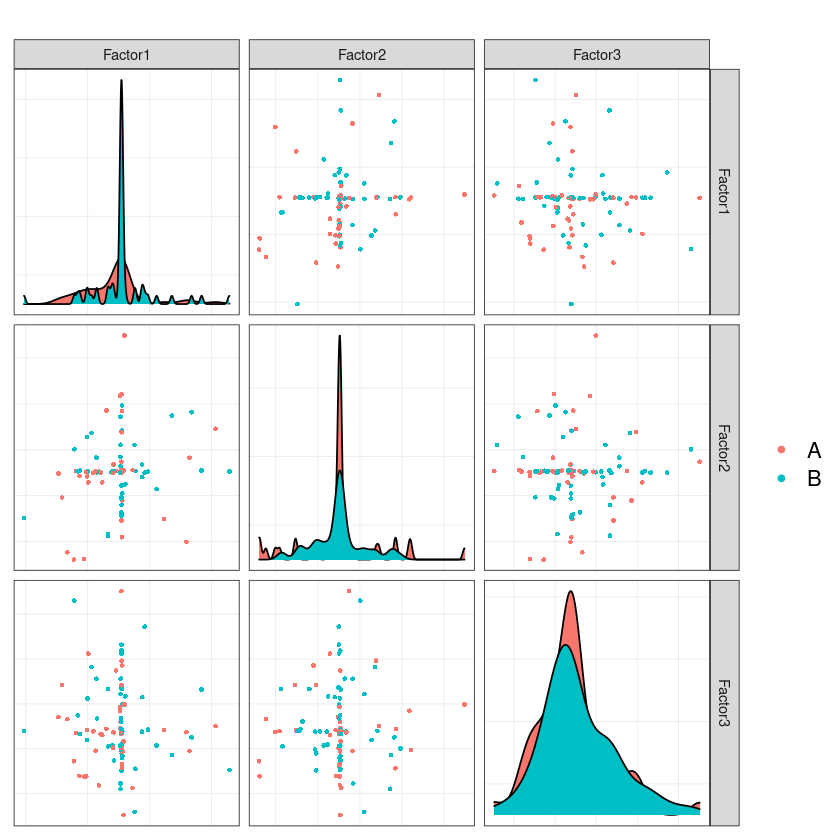

In [25]:
# Combinations of factors
plot_factors(model, 
  factors = 1:3,
  color_by = "condition"
)

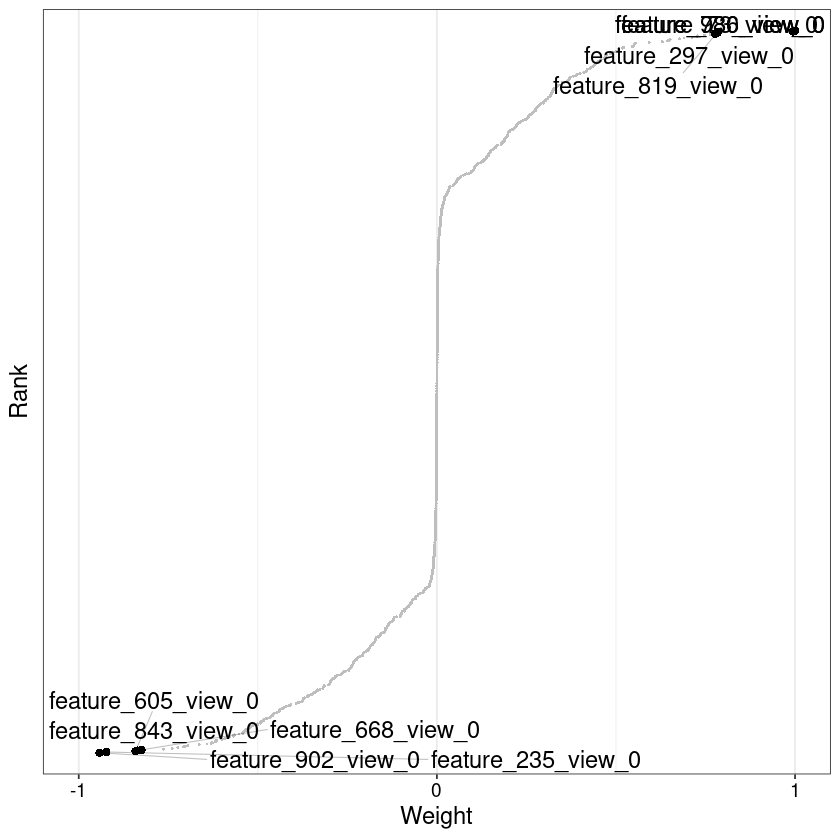

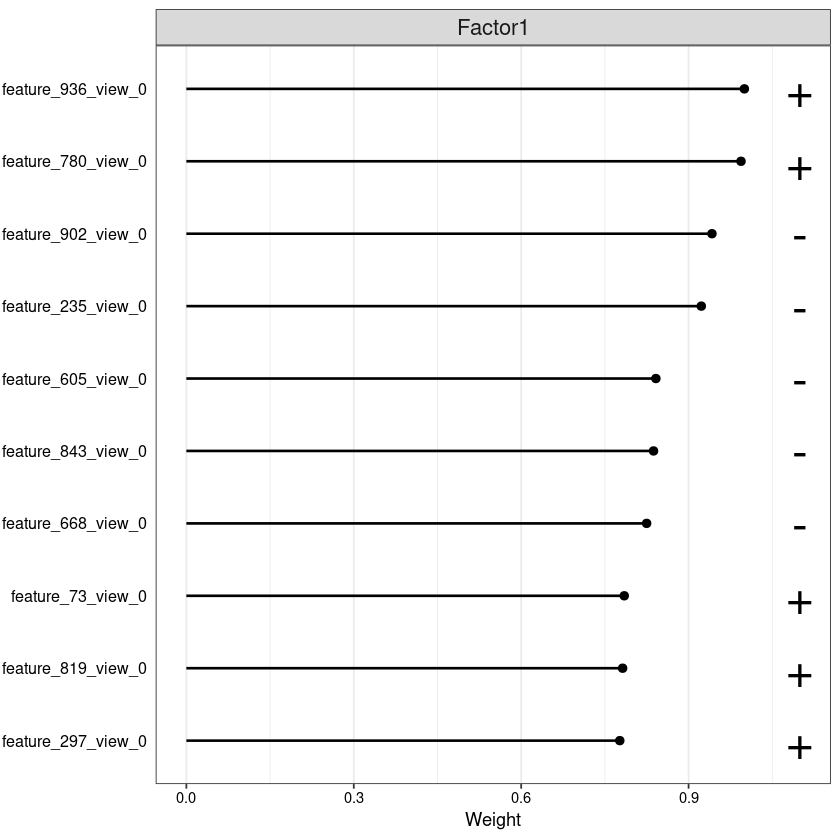

In [29]:
# Feature weights
plot_weights(model,
  view = "view_0",
  factor = 1,
  nfeatures = 10,     # Number of features to highlight
  scale = T,          # Scale weights from -1 to 1
  abs = F             # Take the absolute value?
)

plot_top_weights(model,
  view = "view_0",
  factor = 1,
  nfeatures = 10
)

# Visualisation of patterns in the input data

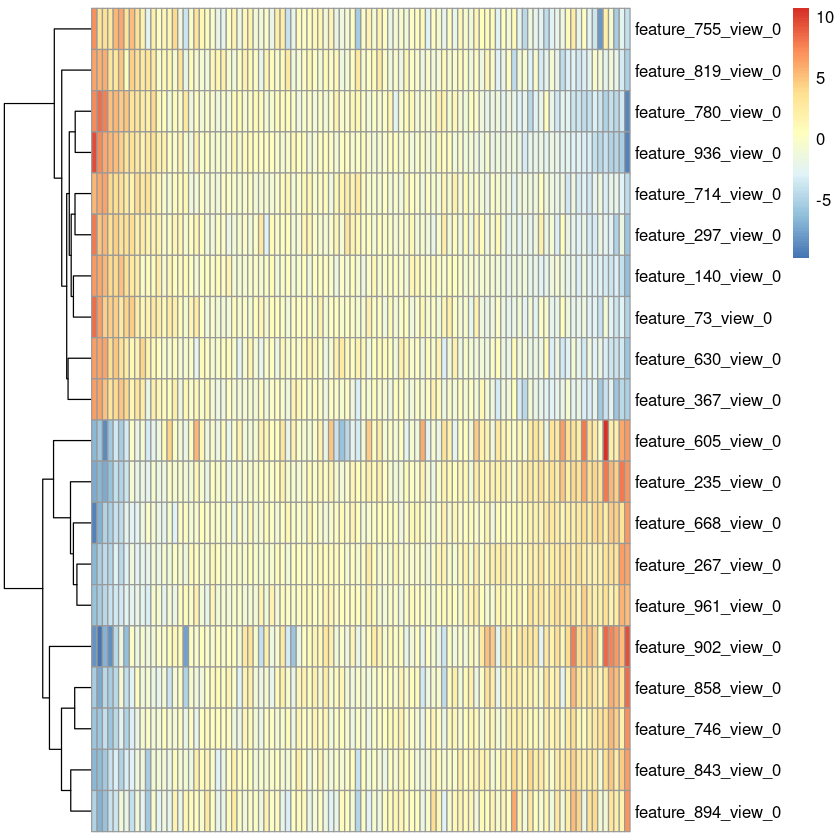

In [30]:
# Heatmap of observations. Top features are selected by its weight in the selected factor. By default, samples are ordered according to their corresponding factor value.

plot_data_heatmap(model,
  view = "view_0",         # view of interest
  factor = 1,             # factor of interest
  features = 20,          # number of features to plot (they are selected by weight)
  
  # extra arguments that are passed to the `pheatmap` function
  cluster_rows = TRUE, cluster_cols = FALSE,
  show_rownames = TRUE, show_colnames = FALSE
)

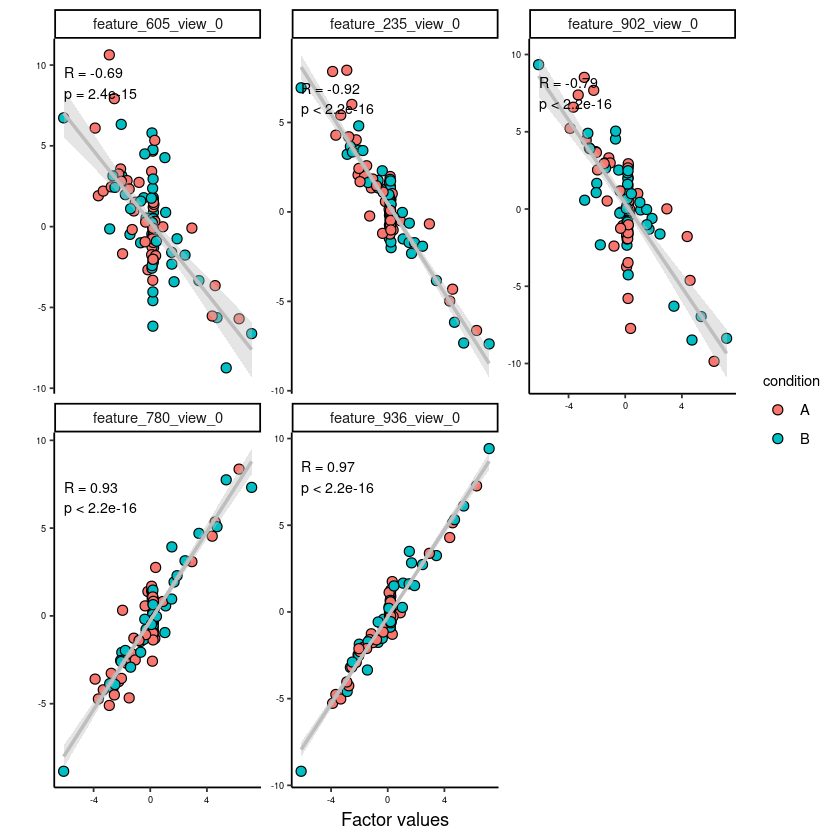

In [32]:
# Scatter plots of observations vs factor values. It is useful to add a linear regression estimate to visualise if the relationship between (top) features and factor values is linear.

plot_data_scatter(model,
  view = "view_0",         # view of interest
  factor = 1,             # factor of interest
  features = 5,           # number of features to plot (they are selected by weight)
  add_lm = TRUE,          # add linear regression
  color_by = "condition"
)